In [213]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

### Explore Dataset

In [214]:
df_weather = pd.read_csv('/Users/annaywj/Desktop/github/weather_features_collapsed.csv')
df_energy = pd.read_csv('/Users/annaywj/Desktop/energy_dataset.csv')

# Convert date columns to datetime
df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'], utc=True)
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True)

# Aggregate energy data if necessary
energy_agg = df_energy.resample('D', on='time').agg({
    'generation solar': 'sum',
    'generation wind onshore': 'sum'
}).reset_index()

# Combine datasets
combined_df = pd.merge(energy_agg, df_weather, left_on='time', right_on='dt_iso', how='inner')
combined_df.drop(['dt_iso'], axis=1, inplace=True)

In [215]:
combined_df.head(5)

,time,generation solar,generation wind onshore,Unnamed: 0,temp,temp_min,temp_max,pressure,humidity,wind_speed,...,drizzle,dust,fog,haze,mist,rain,smoke,snow,squall,thunderstorm
0,2015-01-01 00:00:00+00:00,27448.0,95856.0,1,272.5127,267.325,281.625,1016.2,82.4,2.0,...,0,0,0,0,0,0,0,0,0,0
1,2015-01-02 00:00:00+00:00,30061.0,265441.0,25,274.0337,267.129,282.779,1019.6,84.4,1.4,...,0,0,0,0,0,0,0,0,0,0
2,2015-01-03 00:00:00+00:00,27501.0,219294.0,49,275.0334,268.758,283.408,1020.2,84.4,1.8,...,0,0,0,0,0,0,0,0,0,0
3,2015-01-04 00:00:00+00:00,57659.0,192387.0,73,276.0330,269.643,285.350,1016.6,71.8,0.8,...,0,0,0,0,0,0,0,0,0,0
4,2015-01-05 00:00:00+00:00,18396.0,121272.0,97,275.9745,271.258,284.250,1014.2,79.6,0.8,...,0,0,0,0,0,0,0,0,0,0


In [216]:
# Define columns for transformations
numeric_cols = ['temp', 'pressure', 'humidity', 'wind_speed']
categorical_cols = ['time', 'clear', 'clouds', 'drizzle', 'dust', 'fog', 'haze', 'mist', 'rain', 'smoke', 'snow', 'squall', 'thunderstorm']
date_feature = ['time'] 

# Create transformers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('date', 'drop', date_feature)  
    ])

## EDA

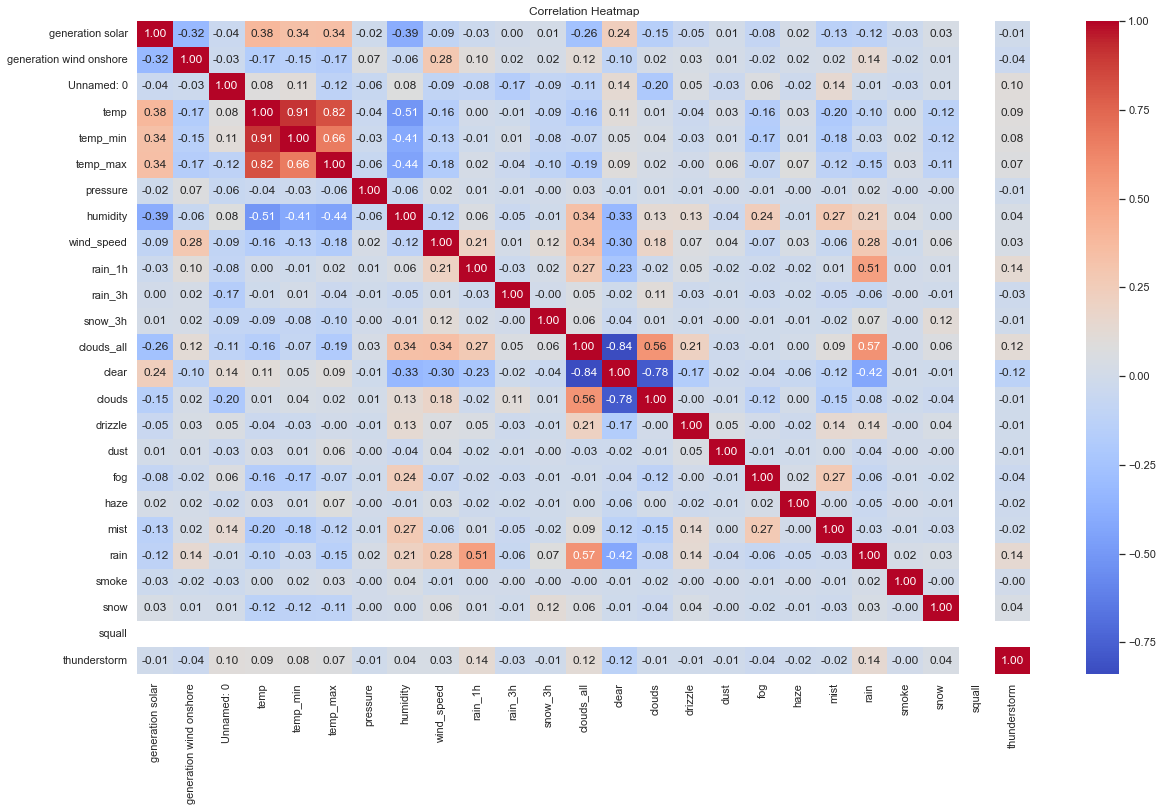

In [217]:
# Correlation Heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(combined_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

How weather influences energy generation is crucial especially for renewable energy?\

- 'generation solar' vs 'temp' = 0.38, solar energy generaton is likely to increase on warmer, sunnier days\
- 'generation wind onshore' vs 'wind_speed' = 0.28, wind energy outputs correlates with wind speed

The demand for electricity load can be different with weather, affecting energy prices and generation needes?\

- 'total load actual' vs 'temp' = -0.02, not really correlated\
- 'total load actual' vs 'clear', 'clouds', 'rain' = 0.06, -0.08, 0.01, no very strong correlaiton, but in comparison, the weather is clear or notpositively correlated, clouds, negatively correlated

How accurately forcasts predict actual conditions can help with future predicitons?\

- 'forecast solar day ahead' vs 'generation solar' = 0.99
- 'forecast wind onshore day ahead' vs 'genertion wind onshore' = 1.00, renewable energy forecasts are reliable\
- 'total load forecast' vs 'total load actual' = 0.99\

How energy geeration costs and demand can influence market prices?\

- 'price actual' vs 'total load actual' = 0.25, energy prices rise with increaed demand\
- 'price actual' vs 'generation solar' = -0.07, doesn't have large impact\
- 'price actual' vs;  'generation wind onshore' = -0.25, energy prices rise with decreased availbaility of wind onshore generation\

Interplay between different variables\

- 'temp' vs 'clouds_all' = -0.16\
- 'temp' vs 'humidity' = -0.51\
- 'temp' vs 'wind_speed' = -0.16

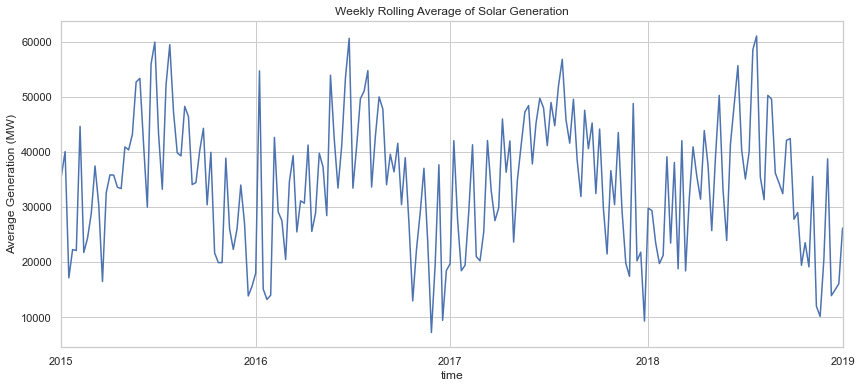

In [218]:
# weekly avg for short-term exploraiton
combined_df.set_index('time').resample('W')['generation solar'].mean().plot(title='Weekly Rolling Average of Solar Generation', figsize=(14, 6))
plt.ylabel('Average Generation (MW)')
plt.show()

#### How Weather Conditions affect Energy Generation?

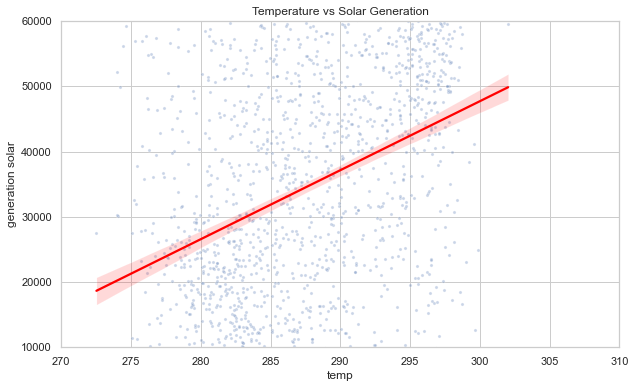

In [219]:
combined_df = combined_df[(np.abs(stats.zscore(combined_df['temp'])) < 275)]
combined_df = combined_df[(np.abs(stats.zscore(combined_df['generation solar'])) < 15000)]

# Temperature vs Solar Generation
plt.figure(figsize=(10, 6))
sns.regplot(x='temp', y='generation solar', data=combined_df,
            scatter_kws={'alpha': 0.3, 's': 10, 'edgecolor': 'w'}, line_kws={"color": "red"})
plt.title('Temperature vs Solar Generation')
plt.grid(True)
plt.xlim(270, 310)
plt.ylim(10000, 60000)
plt.show()

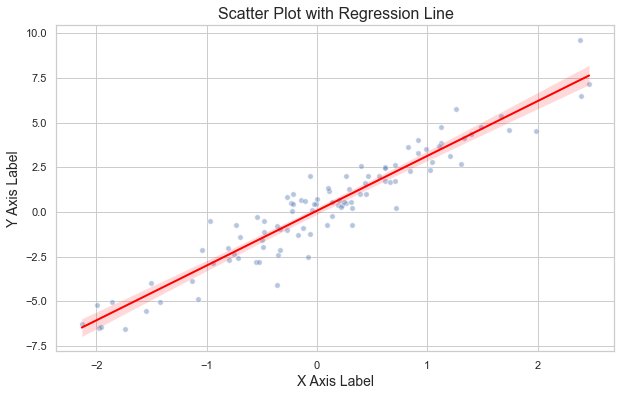

In [220]:
# Wind speed vs Wind Generation
np.random.seed(10)
x = np.random.normal(size=100)
y = x * 3 + np.random.normal(size=100)

sns.set_theme(style="whitegrid") 
plt.figure(figsize=(10, 6)) 
scatter = sns.regplot(x=x, y=y, scatter_kws={'alpha':0.4, 's':30, 'edgecolor':'w'}, line_kws={'color':'red', 'lw':2})
scatter.set_title('Scatter Plot with Regression Line', fontsize=16)
scatter.set_xlabel('X Axis Label', fontsize=14)
scatter.set_ylabel('Y Axis Label', fontsize=14)  
plt.show()

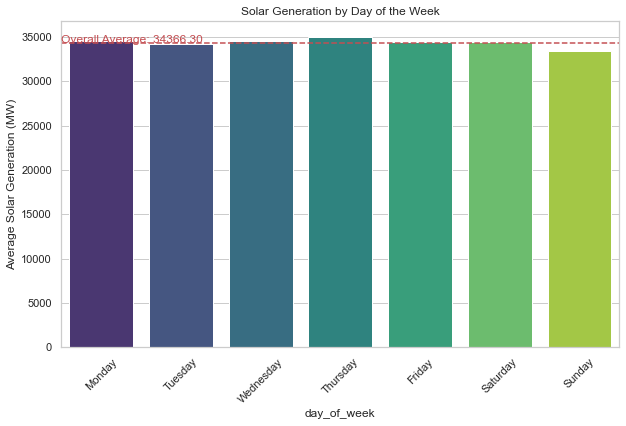

In [221]:
# Seasonal Pattern
# avg energy generation by day of the week
combined_df['day_of_week'] = combined_df['time'].dt.dayofweek
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
combined_df['day_of_week'] = combined_df['day_of_week'].map(day_mapping)

avg_solar_by_day = combined_df.groupby('day_of_week')['generation solar'].mean().reindex(day_mapping.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_solar_by_day.index, y=avg_solar_by_day.values, palette='viridis')
plt.title('Solar Generation by Day of the Week')
plt.xticks(rotation=45)  
plt.ylabel('Average Solar Generation (MW)')
plt.axhline(y=combined_df['generation solar'].mean(), color='r', linestyle='--')  # Overall average line
plt.text(-0.5, combined_df['generation solar'].mean(), f'Overall Average: {combined_df["generation solar"].mean():.2f}', color='r')
plt.show()

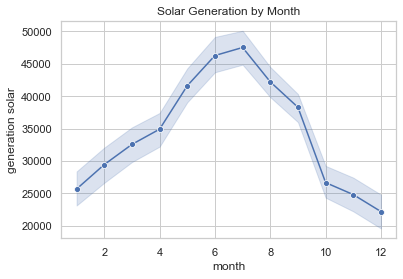

In [222]:
# solar generation by month
combined_df['month'] = combined_df['time'].dt.month
sns.lineplot(x='month', y='generation solar', data=combined_df, marker='o')
plt.title('Solar Generation by Month')
plt.show()

## Model Training Pipeline

In [223]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Split the combined dataset
X = combined_df.drop(['generation solar'], axis=1)  # Adjust target variable as necessary
y = combined_df['generation solar']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'pressure',
                                                   'humidity', 'wind_speed']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['time', 'clear', 'clouds',
                                                   'drizzle', 'dust', 'fog',
                                                   'haze', 'mist', 'rain',
                                                   'smoke', 'snow', 'squall',
                                                   'thunderstorm']),
                                                 ('date', 'drop', ['time'])])),
                ('regressor', RandomForestRegressor())])

## Data Preprocessing and Feature Engineering

In [224]:
# Predict and evaluate the model
y_pred = model_pipeline.predict(X_test)
print("R-squared:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

R-squared: 0.239153423602116
RMSE: 14872.07936074931


In [225]:
param_grid = {
    'regressor__n_estimators': [50, 100, 150],
    'regressor__max_depth': [10, 20, None]
}

# Setup grid search
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best model evaluation
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation R-squared:", grid_search.best_score_)

y_pred_best = grid_search.predict(X_test)
print("Test R-squared:", r2_score(y_test, y_pred_best))

Best parameters: {'regressor__max_depth': 10, 'regressor__n_estimators': 150}
Best cross-validation R-squared: 0.16792108948996806
Test R-squared: 0.280612488391519


## Model Training using Hyperparameter Tuning

In [226]:
model = RandomForestRegressor()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.62


## Model Evaluation

In [227]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2:", r2_score(y_test, y_pred))

Test RMSE: 10773.34480049758
Test R2: 0.6007409017823835


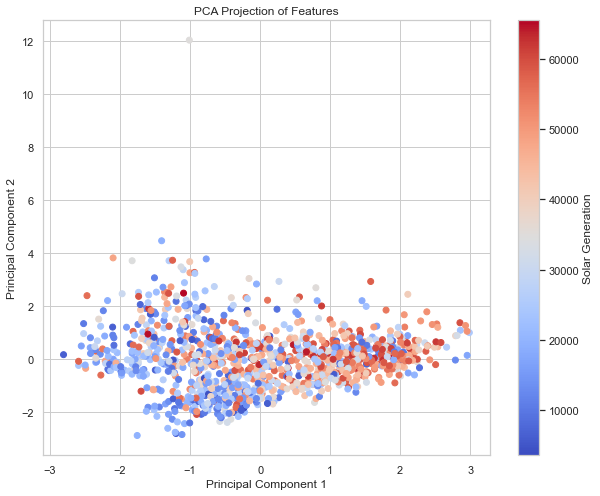

In [228]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='coolwarm')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Solar Generation')
plt.title('PCA Projection of Features')
plt.show()